# example how to extract the WERN features and Copernicus DEM height for reference point collections in openEO
In this example we look on each step to generate a ML usable training dataset from given reference points.

In [1]:
from eo_processing.utils.geoprocessing import get_point_info
from eo_processing.utils.mgrs import gridID_2_epsg
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import geojson
import openeo
from openeo.extra.job_management import MultiBackendJobManager
from eo_processing.utils.helper import init_connection

### loading of the reference points CSV file as PANDAS dataframe
Note: this part has to be later adapted to be more adaptive to different input sources (GeoJSON, parquet files, STAC catalog, ...)

In [2]:
# Load the CSV file into a pandas dataframe
path_td = os.path.normpath(r'C:\Users\BUCHHORM\Downloads\SK_v5_reference-points_EUNIS2012_fixed.csv')
df = pd.read_csv(path_td)

### adding 10m GeoLocation identifier & cell center coordinates plus additional columns/checks
It is crucial that the reference data is in EPSG:4326 - identify the correct columns OR warp coordinates of other EPSG to EPSG:4326.
The MGRSid10 is a unique GeoLocation identifier at 10m spatial resolution in the UTM grid - this allows that reference point labels can be assigned always to the correct EO/non-EO extracted features. The MGRSid10 has 13-digits and specify the lower left corner of the 10x10 m pixel in the MGRS notation. The center_lon/lat represents the center coordinate of the corresponding 10x10m pixel in the UTM grid (10m square covered by the MGRSid10). <br>
The grid20id shows in which 20x20km processing tile the corresponding reference point falls - that allows the pre-grouping of the reference points for efficient processing.

In [3]:
# first we add the unique MGRSid10 identifier and the corresponding center coordinates in EPSG:4326 for the 10m patch
df[['MGRSid10', 'center_lon', 'center_lat', 'grid20id']] = df.apply(lambda row: get_point_info(row['lon'], row['lat']), axis=1, result_type='expand')

In [4]:
# remove non-needed columns when exist
columns_to_remove = ['fid', 'entry', 'x', 'y']
df.drop(columns=[col for col in columns_to_remove if col in df.columns], inplace=True)

In [5]:
# Check and remove duplicate entries in the 'MGRSid10' column
if df['MGRSid10'].duplicated().any():
    duplicates = df[df['MGRSid10'].duplicated(keep=False)]
    print("Duplicate entries found in MGRSid10:")
    print(duplicates[['MGRSid10', 'lon', 'lat', 'center_lon', 'center_lat']])
    # Remove all entries with duplicate MGRSid10
    df = df[~df['MGRSid10'].duplicated(keep=False)]
    print("Duplicates have been removed.")
else:
    print("No duplicate entries in MGRSid10")

Duplicate entries found in MGRSid10:
            MGRSid10        lon        lat  center_lon  center_lat
324    34UCU58116788  19.081292  48.448086   19.081224   48.448101
325    34UCU58136787  19.081471  48.448019   19.081498   48.448016
326    34UCU58126789  19.081411  48.448215   19.081356   48.448193
327    34UCU58116784  19.081256  48.447704   19.081238   48.447741
328    34UCU58126789  19.081406  48.448226   19.081356   48.448193
...              ...        ...        ...         ...         ...
44731  33TXP78931371  17.396612  47.951694   17.396573   47.951731
44732  33TXP78941369  17.396760  47.951573   17.396699   47.951548
44733  33TXP78941369  17.396698  47.951554   17.396699   47.951548
44734  33TXP78891371  17.396035  47.951783   17.396038   47.951742
44735  33TXP78941369  17.396732  47.951563   17.396699   47.951548

[125 rows x 5 columns]
Duplicates have been removed.


In [6]:
# reorder the columns just for better reading
cols = df.columns.tolist()
new_order = ['MGRSid10', 'center_lon', 'center_lat', 'lon', 'lat', 'grid20id']
remaining_cols = [col for col in cols if col not in new_order]
df = df[new_order + remaining_cols]

### convert the DataFrame into a GeoPandas DataFrame with center point geometry

In [7]:
geometry = [Point(xy) for xy in zip(df.center_lon, df.center_lat)]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)
geo_df = geo_df.set_crs('epsg:4326')
print(f'Number of reference points: {len(geo_df)}')

Number of reference points: 45124


<Axes: >

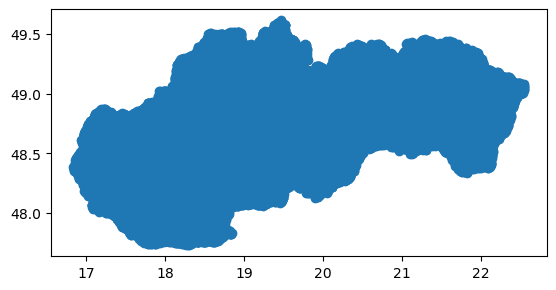

In [8]:
# just visualize for checks
geo_df.geometry.plot()

### split the geodataframe by 20kgrid into stand-alone dataframes for job operation
the 20kgrid represent the best size for working in openEO and is also needed to avoid openEO limitations for extraction. We use the grid20id for the grouping.


In [9]:
split_jobs = [geo_df[geo_df['grid20id'] == tile_id] for tile_id in geo_df['grid20id'].unique()]
print(f'Number of jobs: {len(split_jobs)}')

Number of jobs: 170


<Axes: >

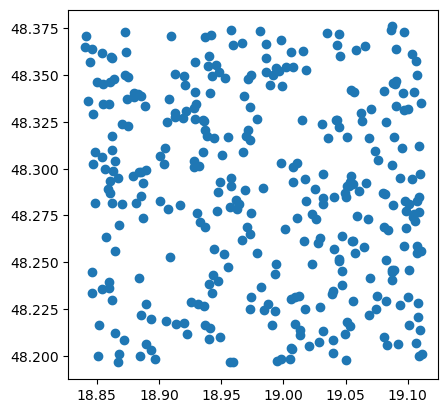

In [10]:
# for visualization we print all the points of one of the 20x20 km tiles (openEO processing tiles identified by grid20id)
split_jobs[100].geometry.plot()

### create the job dataframe with all info to run the openEO `MultiBackendJobManager` for the data extraction
For each job which has to run on openEO we need an extra row in a `pandas.DataFrame` which is handling all information needed by the JobManager to execute the `start_function`. The output dataframe should be savable as a .csv file. <br> <br>
Note: the full information of a sub-geodataframe of points/polygons can be saved into a row of a `pandas.DataFrame` by storing it in a row as string implementing the `geojson.FeatureCollection` interface. To convert the `geopandas.GeoDataFrame` into a string, simply use the `.to_json()` function.


In [27]:
def create_job_dataframe(split_jobs: list[gpd.GeoDataFrame], year: int, file_name_base: str) -> pd.DataFrame:
    """ Create a dataframe from the pre-split GeoDataFrame, containing all the necessary information to run the job.
    
    :param split_jobs: List of GeoDataFrames, each containing job information such as S2 tile ID and geometries.
    :param year: Year for which to create job entries. The start date will be January 1st of this year, and the end date will be January 1st of the following year.
    :param file_name_base: Base file name to be used, with the S2 tile ID appended to create unique file names for each job.
    :return: DataFrame containing job information, including the S2 tile ID, generated file name, start date, end date, and geometry as a JSON object.
    """
    
    columns = ['grid20id', 'epsg', 'file_name', 'start_date', 'end_date', 'geometry']
    dtypes = {'grid20id': 'string', 'epsg': 'UInt16', 'file_name': 'string', 'start_date': 'string', 'end_date': 'string', 'geometry': object}
    rows = []
    for job in split_jobs:
        # set master parameters
        start_date = f'{year}-01-01'
        end_date = f'{year+1}-01-01'
        grid20id = job.grid20id.iloc[0]  # Job dataframes are split depending on the grid20id so we can just take the first one
        epsg = gridID_2_epsg(grid20id)
        file_name = f'{file_name_base}_{grid20id}.csv'
        
        rows.append(
            pd.Series(
                dict(zip(columns, [grid20id, epsg, file_name, start_date, end_date, job[['MGRSid10', 'geometry']].to_json()])),
            )
        )

    return pd.DataFrame(rows).astype(dtypes)

In [28]:
job_df = create_job_dataframe(split_jobs, 2021, 'SK_v5_reference-points_EUNIS2012_features')

In [29]:
# add the number of points to handle in each 20x20km grid cell
def get_point_number(row: pd.Series) -> int:
    """
    :param row: A pandas Series object that contains a geometry field with a GeoJSON string.
    :return: The number of features present in the GeoJSON geometry.
    """
    return len(geojson.loads(row.geometry)['features'])

job_df['n_points'] = job_df.apply(get_point_number, axis=1)

In [30]:
job_df.head()

,grid20id,epsg,file_name,start_date,end_date,geometry,n_points
0,33σXP21,32633,SK_v5_reference-points_EUNIS2012_features_33σX...,2021-01-01,2022-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",118
1,33σXP22,32633,SK_v5_reference-points_EUNIS2012_features_33σX...,2021-01-01,2022-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",323
2,33σXP32,32633,SK_v5_reference-points_EUNIS2012_features_33σX...,2021-01-01,2022-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",424
3,33σXP33,32633,SK_v5_reference-points_EUNIS2012_features_33σX...,2021-01-01,2022-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",375
4,33σXQ30,32633,SK_v5_reference-points_EUNIS2012_features_33σX...,2021-01-01,2022-01-01,"{""type"": ""FeatureCollection"", ""features"": [{""i...",235


### creating the job `start_job` function
The next step is to define a `start_job` function. This function will instruct the `MultiBackendJobManager` on how to initiate a new job on the selected backend. The `start_job` functionality should adhere to the following structure _start_job(row: pd.Series, connection: openeo.Connection, **kwargs)_. <br> <br>
NOTE: for simplification in this example we will only extract the DEM value from the CDSE collection and the WERN features from a external S3 based STAC catalog.

In [31]:
def point_extraction(row: pd.Series, connection: openeo.Connection, provider: str , **kwgs) -> openeo.BatchJob:
    """Start a new job using the specified row out of the jobs DataFrame and connection."""
    
    # Get the variable parameters from the dataframe
    gridID = row["grid20id"]
    start = row["start_date"]
    end = row["end_date"]
    file_name = row["file_name"]
    epsg = int(row["epsg"])
    
    #now we have to load the point geometries for all the points to process
    points_geometry = geojson.loads(row.geometry)
    assert isinstance(points_geometry, geojson.FeatureCollection)

    # Note: for points we do not define a spatial_extent in the collection at all AND run an aggregation_spatial with the GeoJSON FeatureCollection
    # Note2: for polygons we do not define a spatial_extent in the collection at all and later run a cube.filter_spatial(GeoJSON)
    
    # load the DEM from a CDSE collection
    DEM = connection.load_collection(
        "COPERNICUS_30",
        bands=["DEM"]
        )
    # reduce the temporal domain since copernicus_30 collection is "special"
    DEM = DEM.reduce_dimension(dimension='t', reducer=lambda x: x.last(ignore_nodata=True))
    # resample the cube to 10m and EPSG of corresponding UTM 20x20km grid tile
    DEM = DEM.resample_spatial(projection=epsg, resolution=10.0, method="bilinear")
    
    # load the WREN features
    WERN = connection.load_stac("https://catalogue.weed.apex.esa.int/collections/wenr_features")    
        
    # merge the cubes with automatic resampling & projection of the merged in cube
    # Note: the cube on the right side is always merged with a "nearest filter" if re-projection is needed --> for WERN features that is OK
    #       if NOT, then first resample_spatial the WERN cube before doing a merge_cubes
    WERN = WERN.resample_spatial(projection=epsg, resolution=10.0, method="near")
    datacube = DEM.merge_cubes(WERN)
           
    # now we reduce the space to the needed point locations    
    datacube = datacube.aggregate_spatial(points_geometry, reducer="first")
    
    # set the job-parameters (in the pipeline we load that automatically from the settings))
    job_parameters = {
        "driver-memory": "2G",
        "driver-memoryOverhead": "2G",
        "driver-cores": "1",
        "executor-cores": "1",
        "executor-request-cores": "800m",
        "executor-memory": "2500m",
        "executor-memoryOverhead": "2500m",
        "max-executors": "25",
        "executor-threads-jvm": "7",
        "logging-threshold": "info"
        }
    
    # create the job
    job = datacube.create_job(title=os.path.splitext(file_name)[0], 
                              description=f'WERN feature extraction for reference points in tile {gridID}', 
                              out_format='Parquet', 
                              filename_prefix=os.path.splitext(file_name)[0],
                              feature_id_property='MGRSid10',
                              job_options=job_parameters,
                              )
    return job

### run the jobs

In [32]:
# define the output folder (make sure you adapt this to your folder structure)
test_num = 6
out_root = os.path.normpath(r'\\netapp03.vgt.vito.be\people_vol1\tests\openeo\point_extraction')
out_root = os.path.join(out_root, f'test_v{str(test_num)}')
os.makedirs(out_root, exist_ok=True)

In [33]:
# generate a unique name for the job tracker database (here: CSV file)
job_tracker = os.path.normpath(os.path.join(out_root, f'job_tracker_point-extraction_v{str(test_num)}.csv'))

In [37]:
## since I have unicode issues with the grid20id in the metadata dump after a successful job, we test here now a CustomJobManager
# This part can be removed as soon openeo0.35.0 version is out
from openeo import BatchJob
import json
class CustomJobManager(MultiBackendJobManager):
    def on_job_done(self, job: BatchJob, row):
        """
        Handles jobs that have finished. Can be overridden to provide custom behaviour.

        Default implementation downloads the results into a folder containing the title.

        :param job: The job that has finished.
        :param row: DataFrame row containing the job's metadata.
        """
        # TODO: param `row` is never accessed in this method. Remove it? Is this intended for future use?

        job_metadata = job.describe()
        job_dir = self.get_job_dir(job.job_id)
        metadata_path = self.get_job_metadata_path(job.job_id)

        self.ensure_job_dir_exists(job.job_id)
        job.get_results().download_files(target=job_dir)

        with open(metadata_path, "w", encoding='utf8') as f:
            json.dump(job_metadata, f, ensure_ascii=False)



In [38]:
# init of MultiBackendJobManager
#manager = MultiBackendJobManager(root_dir=os.path.normpath(out_root), poll_sleep=15)
manager = CustomJobManager(root_dir=os.path.normpath(out_root), poll_sleep=15)

In [39]:
# create a connection to backend and add this active backend to the jobmanager
backend = 'cdse'  # also possible: cdse-staging, terrascope, development, creodias, sentinelhub
connection = init_connection(backend)
manager.add_backend(backend, connection=connection, parallel_jobs=6)

Authenticated using refresh token.


In [44]:
# run the jobs stand-alone which blocks further usage of the Notebook up to all jobs are done
manager.run_jobs(df=job_df, start_job=point_extraction, job_db=job_tracker)

defaultdict(int,
            {'job_db persist': 9,
             'track_statuses': 8,
             'job_db get_by_status': 1,
             'start_job call': 1,
             'job get status': 2,
             'job start': 1,
             'job launch': 1,
             'run_jobs loop': 8,
             'sleep': 8,
             'job describe': 7,
             'job started running': 1,
             'job finished': 1})

In [45]:
# add the costs to the tracker file
def add_cost_to_csv(
    connection: openeo.Connection,
    file_path: str,
):
    df = gpd.read_file(file_path)
    for i, row in df.iterrows():
        job = connection.job(row["id"])
        try:
            cost = job.describe_job()["costs"]
        except KeyError:
            cost = None
        df.loc[i, "cost"] = cost
    df.to_csv(file_path)

add_cost_to_csv(connection, job_tracker)

### combine the single results into one training data file
First load all the single parquet files of the jobs into `pandas.DataFrame` and combine.

In [46]:
# load the job_tracker file into a pandas DataFrame
df_tracker = pd.read_csv(job_tracker)

In [47]:
# Check if all values in column "status" have the value "finished"
all_finished = df_tracker['status'].eq('finished').all()
if all_finished:
    print("All jobs are finished.")
else:
    print("Some jobs are not finished. Reset the non finished status rows to 'not_started' flag and restart the manager.run_jobs() line manually.")

All jobs are finished.


In [48]:
# print the costs of the full job
print(f'The feature extraction for {df_tracker.n_points.sum()} reference points has cost overall {df_tracker.cost.sum()} credits ({df_tracker.cost.sum() * 0.01} EURO). ')

The feature extraction for 45124 reference points has cost overall 680.0 credits (6.8 EURO). 


In [49]:
# get the list of links to the job parquet files
df_tracker['path_result'] = df_tracker['id'].apply(lambda x: os.path.normpath(os.path.join(out_root, f'job_{x}', 'timeseries.parquet')))
path_Results = df_tracker['path_result'].tolist()

In [50]:
# read parquet files and combine
combined_df = pd.concat([pd.read_parquet(p) for p in path_Results], ignore_index=True)

In [51]:
# get a list of extracted feature names
feature_names = [x for x in combined_df.columns.tolist() if x not in geo_df.columns.tolist()]
# remove some openEO generated columns
feature_names = [x for x in feature_names if x not in ["date", "feature_index"]]

In [53]:
# run a check before merging row of results == row of input
assert len(combined_df) == len(geo_df)

In [54]:
# merge in results
combined_df = combined_df.set_index('MGRSid10')
geo_df = geo_df.set_index('MGRSid10')
result_df = geo_df.join(combined_df[feature_names], how='left').reset_index()

In [55]:
result_df.head()

,MGRSid10,center_lon,center_lat,lon,lat,grid20id,valid_L1,valid_L2,valid_L3,label_L1,...,dist,occur,pop,bdod,cec,cfvo,clay,phh2o,sand,soc
0,33UXP57473908,17.118710,48.185468,17.118680,48.185489,33σXP21,True,True,True,C,...,6295.0,0.0,149.0,131.0,200.0,138.0,271.0,63.0,307.0,243.0
1,33UXP59864327,17.152421,48.222541,17.152425,48.222568,33σXP22,True,True,True,C,...,9223.0,0.0,407.0,132.0,210.0,136.0,254.0,62.0,325.0,222.0
2,33UXP63034439,17.195500,48.231803,17.195542,48.231791,33σXP32,True,True,True,C,...,9172.0,0.0,65.0,136.0,186.0,103.0,255.0,66.0,278.0,192.0
3,33UXP62884673,17.194382,48.252879,17.194425,48.252869,33σXP32,True,True,True,C,...,11402.0,0.0,74.0,133.0,172.0,167.0,236.0,60.0,298.0,204.0
4,33UXP63564713,17.203691,48.256300,17.203641,48.256284,33σXP32,True,True,True,C,...,11718.0,0.0,606.0,133.0,200.0,148.0,259.0,63.0,301.0,209.0


In [56]:
# save to disk as GeoPackage
file_name = os.path.basename(path_td).replace('.csv', '_Features_alpha1.gpkg')
path_gpkg = os.path.normpath(os.path.join(out_root, file_name))
result_df.to_file(path_gpkg, driver='GPKG')